In [ ]:
import numpy as np
import pymc as pm

np.random.seed(0)

n_models = 3
failure_rate_means = np.array([0.02, 0.05, 0.10])  
failure_rate_stds  = np.array([0.005, 0.01, 0.015])
cost_means  = np.array([100.0, 80.0, 50.0])        
cost_stds   = np.array([  5.0,  4.0,  3.0])        
accuracy_mean, accuracy_std = 0.90, 0.05           

actual_failure_probs = np.random.normal(failure_rate_means, failure_rate_stds)
actual_failure_probs = np.clip(actual_failure_probs, 0.001, 0.999)  # ensure in [0,1]
print(f"True failure probability for each model (unknown to us): {actual_failure_probs}")

N_train_per_model = 10
X_train = []
Y_train = []
for i in range(n_models):
    x_vec = np.zeros(n_models)
    x_vec[i] = 1
    outcomes = np.random.binomial(1, actual_failure_probs[i], size=N_train_per_model)
    for outcome in outcomes:
        X_train.append(x_vec.copy())
        Y_train.append(outcome)
X_train = np.array(X_train)
Y_train = np.array(Y_train)

total_data = len(Y_train)
fail_counts = [Y_train[(X_train[:, i]==1)].sum() for i in range(n_models)]
print(f"Generated {total_data} data points (drive-years). Failures observed per model: {fail_counts}")

True failure probability for each model (unknown to us): [0.02882026 0.05400157 0.11468107]
Generated 30 data points (drive-years). Failures observed per model: [np.int64(0), np.int64(1), np.int64(1)]


In [2]:
# Build and train Bayesian Neural Network (BNN) in PyMC
with pm.Model() as bnn_model:
    # Priors on weights and biases (Normal(0,1))
    w_in = pm.Normal("w_in", mu=0, sigma=1, shape=(n_models, 2))   # weights from input layer -> hidden layer (3x2)
    b_hidden = pm.Normal("b_hidden", mu=0, sigma=1, shape=(2,))    # biases for hidden layer (2,)
    w_out = pm.Normal("w_out", mu=0, sigma=1, shape=(2,))          # weights from hidden -> output (2,)
    b_out = pm.Normal("b_out", mu=0, sigma=1)                      # bias for output layer (scalar)
    # Neural network likelihood
    hidden_activation = pm.math.tanh(pm.math.dot(X_train, w_in) + b_hidden)   #  Hidden layer outputs
    output_logit = pm.math.dot(hidden_activation, w_out) + b_out             #  Linear output
    p = pm.math.sigmoid(output_logit)                                       #  Predicted failure probability
    y = pm.Bernoulli("y", p=p, observed=Y_train)                            #  Bernoulli likelihood for observed outcomes

    # Inference: sample from posterior
    trace = pm.sample(draws=500, tune=500, chains=1, target_accept=0.95, random_seed=0, progressbar=False)

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w_in, b_hidden, w_out, b_out]
Sampling 1 chain for 500 tune and 500 draw iterations (500 + 500 draws total) took 1 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
posterior_samples = trace.posterior  # xarray with samples
draws = posterior_samples.sizes["draw"]
chains = posterior_samples.sizes["chain"]         # обычно = 1
p_samples = np.zeros((chains * draws, n_models))  # [n_total_draws, n_models]

row = 0
for c in range(chains):
    for d in range(draws):
        W_in  = posterior_samples["w_in"     ].sel(chain=c, draw=d).values    # (n_models, 2)
        B_h   = posterior_samples["b_hidden"].sel(chain=c, draw=d).values     # (2,)
        W_out = posterior_samples["w_out"   ].sel(chain=c, draw=d).values     # (2,)
        B_out = float(posterior_samples["b_out"].sel(chain=c, draw=d).values) # scalar

        # Compute predicted p_i for each drive model
        for i in range(n_models):
            x_i = np.zeros(n_models); x_i[i] = 1          # one-hot input
            h = np.tanh(x_i @ W_in + B_h)                 # hidden layer (len 2)
            logit = h @ W_out + B_out                     # scalar
            p_samples[row, i] = 1.0 / (1.0 + np.exp(-logit))
        row += 1

# Summaries
p_mean = p_samples.mean(axis=0)
p_std  = p_samples.std(axis=0)
for i in range(n_models):
    print(f"Model {i+1}: p ≈ {p_mean[i]:.3f} ± {p_std[i]:.3f}")

Model 1: p ≈ 0.102 ± 0.069
Model 2: p ≈ 0.116 ± 0.066
Model 3: p ≈ 0.117 ± 0.067


In [ ]:
R = 120.0  
replacement_factor = 1.2 
N_total = 100  

def simulate_profit(X, n_samples=10000):
    X = np.array(X, dtype=int)
    idx = np.random.randint(0, p_samples.shape[0], size=n_samples)
    p_draws = p_samples[idx]  # shape (n_samples, n_models)
    cost_draws = np.random.normal(cost_means, cost_stds, size=(n_samples, n_models))
    cost_draws = np.clip(cost_draws, 0, None)  # no negative costs
    total_profit = np.zeros(n_samples)
    for i in range(n_models):
        fails = np.random.binomial(X[i], p_draws[:, i])
        total_profit += R * X[i] - cost_draws[:, i] * X[i] - cost_draws[:, i] * replacement_factor * fails
    return total_profit

X_example = np.array([34, 33, 33])
profits = simulate_profit(X_example, n_samples=10000)
mean_profit = profits.mean()
q05 = np.quantile(profits, 0.05) 
cvar_05 = profits[profits <= q05].mean()  
print(f"Example strategy X = {X_example}:")
print(f"  Expected Profit = ${mean_profit:,.0f}")
print(f"  CVaR (α=0.05)   = ${cvar_05:,.0f} (average profit in worst 5% scenarios)")

Example strategy X = [34 33 33]:
  Expected Profit = $3,287
  CVaR (α=0.05)   = $1,656 (average profit in worst 5% scenarios)


In [ ]:
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.optimize import minimize

# Define the optimization problem
class DriveAllocationProblem(ElementwiseProblem):
    def __init__(self, N_total):
        super().__init__(n_var=2, n_obj=2, n_constr=1, xl=0, xu=N_total)
        self.N_total = N_total
    def _evaluate(self, x, out, *args, **kwargs):
        N_A = int(round(x[0])); N_B = int(round(x[1]))
        N_C = self.N_total - N_A - N_B
        g = N_A + N_B - self.N_total  # must be <= 0
        if g > 0:
            out["F"] = [1e6, 1e6]
        else:
            profits = simulate_profit([N_A, N_B, N_C], n_samples=2000)
            mean_profit = profits.mean()
            q05 = np.quantile(profits, 0.05)
            cvar_05 = profits[profits <= q05].mean() if np.any(profits <= q05) else profits.min()
            out["F"] = [-mean_profit, -cvar_05]
        out["G"] = [g]

# Instantiate problem for N_total drives
problem = DriveAllocationProblem(N_total=N_total)

algorithm = NSGA2(
    pop_size=300,                 # больше разнообразия
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=20, vtype=float, repair=RoundingRepair()),
    mutation=PM(prob=0.6,  eta=20, vtype=float, repair=RoundingRepair()),
    eliminate_duplicates=False
)
res = minimize(problem, algorithm,
               ('n_gen', 400),    # дольше «эволюционируем»
               seed=0, verbose=True)

X_solutions = res.X  
F_values = res.F     
is_dominated = np.zeros(len(X_solutions), dtype=bool)
for i in range(len(X_solutions)):
    for j in range(len(X_solutions)):
        if i != j:
            # domination check: j dominates i if F[j] <= F[i] in both objs and < in at least one
            if np.all(F_values[j] <= F_values[i]) and np.any(F_values[j] < F_values[i]):
                is_dominated[i] = True
                break
pareto_X = X_solutions[~is_dominated]
pareto_F = F_values[~is_dominated]

print("Pareto-optimal strategies (N_A, N_B, N_C):")
for sol in pareto_X:
    N_A, N_B = int(round(sol[0])), int(round(sol[1]))
    N_C = N_total - N_A - N_B
    print(f"  Allocation = [{N_A}, {N_B}, {N_C}]")
print("\nMetrics for Pareto strategies:")
for sol, obj in zip(pareto_X, pareto_F):
    N_A, N_B = int(round(sol[0])), int(round(sol[1])); N_C = N_total - N_A - N_B
    mean_prof = -obj[0]
    cvar_prof = -obj[1]
    print(f"  X=[{N_A},{N_B},{N_C}]:  Expected Profit = ${mean_prof:,.0f},  CVaR(5%) = ${cvar_prof:,.0f}")

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |      300 |      1 |  0.000000E+00 |  1.679667E+01 |             - |             -
     2 |      600 |      2 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     3 |      900 |      1 |  0.000000E+00 |  0.000000E+00 |  1.278390E+02 |         ideal
     4 |     1200 |      2 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     5 |     1500 |      1 |  0.000000E+00 |  0.000000E+00 |  4.942466E+01 |         ideal
     6 |     1800 |      1 |  0.000000E+00 |  0.000000E+00 |  0.000000E+00 |             f
     7 |     2100 |      3 |  0.000000E+00 |  0.000000E+00 |  1.0000000000 |         ideal
     8 |     2400 |      4 |  0.000000E+00 |  0.000000E+00 |  0.8577614761 |         ideal
     9 |     2700 |      6 |  0.000000E+00 |  0.000000E+00 |  0.0649906583 |         ideal
    10 |     3000 |      2 |  0.000000E+00 |  0.000000E+00 |  0.0932263253 |         ideal

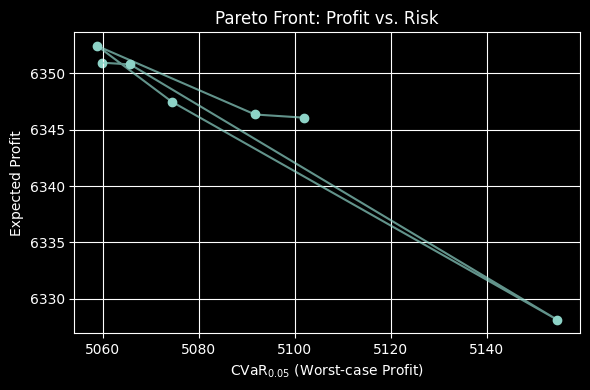

In [11]:
import matplotlib.pyplot as plt

# Calculate mean profit and CVaR for Pareto solutions for plotting
mean_profits = -pareto_F[:,0]
cvar_values = -pareto_F[:,1]
plt.figure(figsize=(6,4))
plt.scatter(cvar_values, mean_profits, color='C0')
plt.plot(cvar_values, mean_profits, color='C0', alpha=0.7)
plt.xlabel("CVaR$_{0.05}$ (Worst-case Profit)")
plt.ylabel("Expected Profit")
plt.title("Pareto Front: Profit vs. Risk")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:

idx = np.argmax((-pareto_F[:,0]) / pareto_F[:,1])
best_X = pareto_X[idx]
mu_best, cvar_best = -pareto_F[idx,0], pareto_F[idx,1]

print("📌 Recommended procurement vector:")
for m, units in zip(range(n_models), best_X):
    print(f"  • {m}: {units} units")
print(f"\nExpected mean profit: {mu_best:,.0f}")
print(f"CVaR0.5: {cvar_best:,.0f}")
    

📌 Recommended procurement vector:
  • 0: 0 units
  • 1: 0 units

Expected mean profit: 6,328
CVaR0.5: -5,155
